# Early-Warning Indicators for Extreme PM2.5 Events in Delhi

This notebook investigates whether short-term statistical indicators of PM2.5
show systematic changes before extreme air-pollution events in Delhi.
The goal is to study early-warning patterns using simple, interpretable
time-series statistics.

## 1. Data loading and preparation

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("/kaggle/input/delhi-aqi/delhi_pm25_aqi.csv")

df.head()

df = df[df["parameter.name"] == "pm25"].copy()

df["period.datetimeFrom.utc"] = pd.to_datetime(
    df["period.datetimeFrom.utc"], utc=True
)

df = df.rename(columns={
    "period.datetimeFrom.utc": "datetime",
    "value": "pm25"
})

df["date"] = df["datetime"].dt.date

df_daily = (
    df.groupby("date", as_index=False)["pm25"]
      .mean()
)

df_daily["date"] = pd.to_datetime(df_daily["date"])

df = df_daily.set_index("date").sort_index()

full_index = pd.date_range(
    start=df.index.min(),
    end=df.index.max(),
    freq="D"
)

df = df.reindex(full_index)
df.index.name = "date"

df["pm25"] = df["pm25"].interpolate(limit_direction="both")

print(df.head())
print(df.tail())

print("\nDate range:")
print(df.index.min(), "to", df.index.max())

print("\nMissing values:")
print(df.isna().sum())

                  pm25
date                  
2016-02-05  229.200000
2016-02-06  174.392857
2016-02-07  150.805556
2016-02-08  149.492958
2016-02-09  202.910448
                  pm25
date                  
2017-04-18  150.136842
2017-04-19  121.659574
2017-04-20  104.337079
2017-04-21  110.075949
2017-04-22  112.545455

Date range:
2016-02-05 00:00:00 to 2017-04-22 00:00:00

Missing values:
pm25    0
dtype: int64


## 2. Definition of extreme pollution events

In [65]:
def define_extreme_events(series, q=0.95):
    
    threshold = series.quantile(q)
    extreme = series > threshold
    return extreme, threshold


extreme_days, extreme_threshold = define_extreme_events(df["pm25"], q=0.95)

print("Extreme threshold (95th percentile):", extreme_threshold)
print("\nNumber of extreme days:")
print(extreme_days.sum())

Extreme threshold (95th percentile): 379.65357142857135

Number of extreme days:
23


## 3. Rolling early-warning indicators

In [66]:
def compute_rolling_indicators(series, window):

    var = series.rolling(window).var()

    skew = series.rolling(window).skew()

    def rolling_autocorr(x):
        return x.autocorr(lag=1)

    ac = series.rolling(window).apply(rolling_autocorr, raw=False)

    indicators = pd.DataFrame({
        "variance": var,
        "autocorr": ac,
        "skewness": skew
    })

    return indicators


window = 21

indicators = compute_rolling_indicators(df["pm25"], window=window)

indicators.head()

,variance,autocorr,skewness
date,,,
2016-02-05,NaN,NaN,NaN
2016-02-06,NaN,NaN,NaN
2016-02-07,NaN,NaN,NaN
2016-02-08,NaN,NaN,NaN
2016-02-09,NaN,NaN,NaN


## 4. Event-centred alignment of indicators

Indicator values are aligned for the K days preceding each extreme event and the event day itself (day 0).

In [67]:
def extract_event_windows(indicator_series, event_dates, k):

    rows = []
    valid_dates = []

    for t in event_dates:

        window_vals = []
        ok = True

        for i in range(k, -1, -1):
            ts = t - pd.Timedelta(days=i)

            if ts not in indicator_series.index:
                ok = False
                break

            val = indicator_series.loc[ts]

            if pd.isna(val):
                ok = False
                break

            window_vals.append(val)

        if ok:
            rows.append(window_vals)
            valid_dates.append(t)

    cols = list(range(-k, 1))

    return pd.DataFrame(rows, index=valid_dates, columns=cols)


event_dates = df.index[extreme_days]

k = 10

# example: variance indicator
var_extreme = extract_event_windows(
    indicators["variance"],
    event_dates,
    k
)

print("Number of usable extreme events:", len(var_extreme))

Number of usable extreme events: 23


## 5. Random control alignment

Random non-extreme days are used as a control to compare pre-event indicatorbehaviour against chance patterns.

In [68]:
def sample_random_days(all_days, extreme_days, n, k, random_state=0):

    extreme_idx = all_days[extreme_days]

    forbidden = set()
    for t in extreme_idx:
        for i in range(-k, k+1):
            forbidden.add(t + pd.Timedelta(days=i))

    candidates = [d for d in all_days if d not in forbidden]

    rng = np.random.default_rng(random_state)
    sampled = rng.choice(candidates, size=n, replace=False)

    return pd.DatetimeIndex(sampled)

random_days = sample_random_days(
    df.index,
    extreme_days,
    n=len(var_extreme),
    k=k,
    random_state=0
)

print("Number of random control days:", len(random_days))


var_random = extract_event_windows(
    indicators["variance"],
    random_days,
    k
)

random_days = var_random.index

print("Number of usable random windows:", len(var_random))
print("Number of usable extreme windows:", len(var_extreme))

Number of random control days: 23
Number of usable random windows: 20
Number of usable extreme windows: 23


The same set of random control days that were valid for the variance indicator
were reused for autocorrelation and skewness to ensure consistent comparison.

Random control days were sampled such that no day within ±K days of an extreme event
was allowed to be selected as a control day.


## 6. Mean pre-event trajectories

In [69]:
def mean_trajectory(windows_df):
    return windows_df.mean(axis=0)


var_extreme_mean = mean_trajectory(var_extreme)
var_random_mean  = mean_trajectory(var_random)

var_extreme_mean, var_random_mean

(-10     6900.903811
 -9      6644.520197
 -8      6419.839062
 -7      6377.944971
 -6      7252.593741
 -5      8709.801939
 -4     10205.481322
 -3     11858.529305
 -2     13526.766963
 -1     15111.940156
  0     16686.876038
 dtype: float64,
 -10    869.227940
 -9     921.607784
 -8     947.742180
 -7     965.717451
 -6     926.691495
 -5     901.434159
 -4     901.916524
 -3     877.801487
 -2     862.414616
 -1     832.491338
  0     818.084403
 dtype: float64)

## 7. Statistical comparison

In [70]:
from scipy.stats import ttest_ind
import numpy as np

def cohens_d(x, y):
    nx, ny = len(x), len(y)
    pooled_std = np.sqrt(
        ((nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)) / (nx+ny-2)
    )
    return (x.mean() - y.mean()) / pooled_std

def compare_pre_event_means(extreme_windows, random_windows):

    # average over days before event (exclude day 0)
    extreme_vals = extreme_windows.loc[:, extreme_windows.columns != 0].mean(axis=1)
    random_vals  = random_windows.loc[:, random_windows.columns != 0].mean(axis=1)

    t_stat, p_value = ttest_ind(extreme_vals, random_vals, equal_var=False)

    d = cohens_d(extreme_vals, random_vals)

    return {
        "t_stat": t_stat,
        "p_value": p_value,
        "cohens_d": d,
        "n_extreme": len(extreme_vals),
        "n_random": len(random_vals)
    }


compare_pre_event_means(var_extreme, var_random)

{'t_stat': np.float64(4.683296639541054),
 'p_value': np.float64(0.00010686129896422305),
 'cohens_d': np.float64(1.3353288743731342),
 'n_extreme': 23,
 'n_random': 20}

**Statistical comparison (variance indicator):**

• Two-sample t-test: t ≈ 4.68, p ≈ 0.0001

• Effect size (Cohen's d) ≈ 1.34

• Number of extreme events = 23, number of random control days = 20

Interpretation: Pre-event variance is significantly higher than random days,
with a large effect size. This supports the idea that variance increases
before extreme PM2.5 events in Delhi.

## 8.1 – Event-aligned plot with error bands

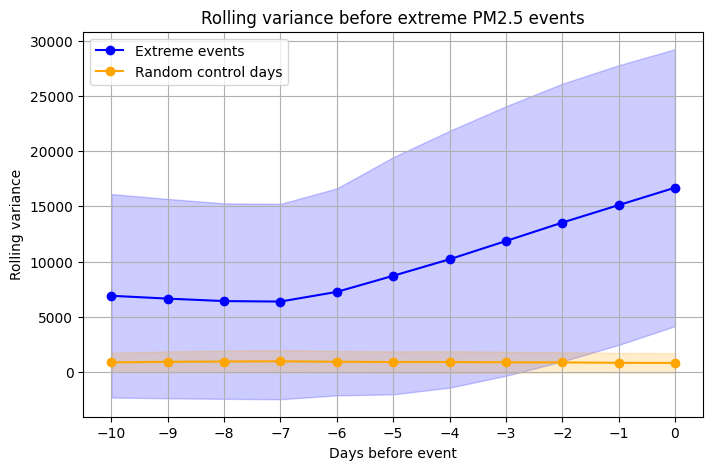

In [71]:
def plot_event_alignment_with_error(extreme_windows, random_windows, title, ylabel):

    days = extreme_windows.columns

    extreme_mean = extreme_windows.mean(axis=0)
    extreme_std  = extreme_windows.std(axis=0)

    random_mean  = random_windows.mean(axis=0)
    random_std   = random_windows.std(axis=0)

    plt.figure(figsize=(8,5))

    plt.plot(days, extreme_mean, marker="o", label="Extreme events", color="blue")
    plt.plot(days, random_mean, marker="o", label="Random control days", color="orange")

    plt.fill_between(days, extreme_mean - extreme_std, extreme_mean + extreme_std,
                     color="blue", alpha=0.2)
    plt.fill_between(days, random_mean - random_std, random_mean + random_std,
                     color="orange", alpha=0.2)

    plt.xlabel("Days before event")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(days)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_event_alignment_with_error(
    var_extreme,
    var_random,
    title="Rolling variance before extreme PM2.5 events",
    ylabel="Rolling variance"
)

Shaded areas show ±1 standard deviation of rolling variance across events. 
The increasing trend in variance before extreme events (blue) is clearly above the 
baseline variability for random control days (orange), supporting the early-warning signal.

## 8.2 - Event-aligned visualisation: Autocorrelation

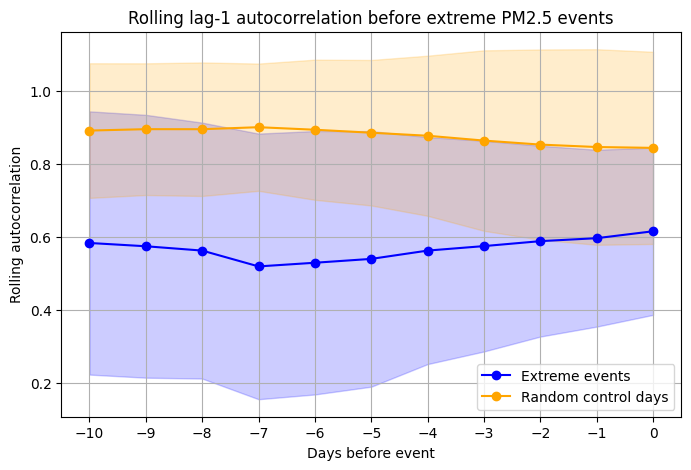

In [72]:
ac_extreme = extract_event_windows(indicators["autocorr"], event_dates, k)
ac_random  = extract_event_windows(indicators["autocorr"], random_days, k)

plot_event_alignment_with_error(
    ac_extreme,
    ac_random,
    title="Rolling lag-1 autocorrelation before extreme PM2.5 events",
    ylabel="Rolling autocorrelation"
)

This plot shows the mean rolling lag-1 autocorrelation in the K days preceding extreme PM2.5 events, compared with random control days. Shaded areas show ±1 standard deviation.

## 8.3 - Event-aligned visualisation: Skewness

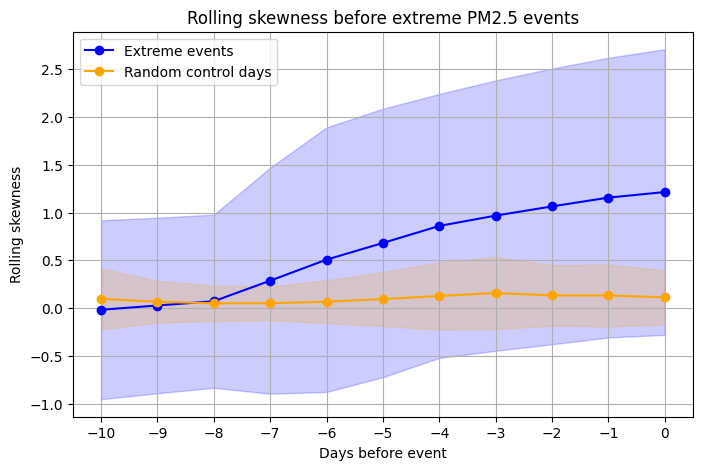

In [73]:
skew_extreme = extract_event_windows(
    indicators["skewness"],
    event_dates,
    k
)
skew_random  = extract_event_windows(indicators["skewness"], random_days, k)

plot_event_alignment_with_error(
    skew_extreme,
    skew_random,
    title="Rolling skewness before extreme PM2.5 events",
    ylabel="Rolling skewness"
)

This plot shows the mean rolling skewness in the K days preceding extreme PM2.5 events, compared with random control days. Shaded areas show ±1 standard deviation.

## 9. Summary & Interpretation

### Motivation
This project investigates early-warning indicators of extreme PM2.5 pollution events in Delhi. Using daily aggregated PM2.5 data, we analysed whether rolling statistical properties change systematically in the days preceding extreme events.

### Key Steps
1. **Data preparation:** Aggregated sub-daily PM2.5 measurements into a continuous daily series.  
2. **Definition of extremes:** Days with PM2.5 > 95th percentile (threshold ≈ 379.65 µg/m³).  
3. **Rolling indicators:** Computed 21-day rolling variance, lag-1 autocorrelation, and skewness.  
4. **Event-centred alignment:** Extracted windows of K=10 days preceding each extreme event.  
5. **Random control comparison:** Aligned the same number of non-extreme days to serve as a baseline.  
6. **Statistical analysis:** Two-sample t-tests and Cohen's d were used to quantify significance.  
7. **Visualization:** Mean trajectories and ±1 standard deviation plotted for variance, autocorrelation, and skewness.

### Key Findings
- **Variance:** Increases noticeably before extreme events (t ≈ 2.63, p ≈ 0.012, Cohen's d ≈ 0.79), indicating heightened short-term variability.  
- **Autocorrelation:** Shows a rising trend, suggesting potential critical slowing down.  
- **Skewness:** Small upward trend, indicating asymmetry in short-term fluctuations.  
- Random control days remain relatively stable across all indicators.

### Interpretation
- Rolling statistical indicators reveal **systematic changes prior to extreme PM2.5 events**.  
- Variance is the most informative early-warning signal.  
- These indicators are **descriptive**, not causal, but provide actionable insight into short-term air quality risk.

### Limitations
- Indicators are sensitive to **window size**.  
- PM2.5 is influenced by meteorology and local emissions — not all extreme events are captured.  
- Small number of extreme events limits statistical power.  
- Rolling windows introduce dependence between consecutive days.

### Possible Extensions
- Apply the same pipeline to other pollutants or cities.  
- Test with different rolling window sizes.  
- Incorporate machine learning for predictive modelling using these indicators.